In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from glob import glob
s=glob('/content/drive/MyDrive/flowers/*')

In [5]:
s

['/content/drive/MyDrive/flowers/test', '/content/drive/MyDrive/flowers/train']

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [29]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [30]:
import os
# Define the data directory
data_dir = '/content/drive/MyDrive/flowers'

# Print the contents of the data directory to verify the folder structure
print(os.listdir(data_dir))

# Expect to see: ['train', 'test'] or similar based on your data.
# Ensure 'train' and 'test' folders exist and are located inside 'flowers' directory.

# Within each of the subfolders 'train' and 'test', there should be a folder for each class
# i.e. 'daisy', 'dandelion'  and those folders contain the images.

['test', 'train']


In [31]:
# Define the data directory
data_dir = '/content/drive/MyDrive/flowers'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
#image_datasets

In [32]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 2756, 'test': 56}


['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [33]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [34]:
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 1.2442 Acc: 0.5864
test Loss: 0.8320 Acc: 0.8393
train Loss: 0.8713 Acc: 0.6956
test Loss: 0.8977 Acc: 0.8214
train Loss: 0.8360 Acc: 0.6981
test Loss: 0.8128 Acc: 0.8393
train Loss: 0.7721 Acc: 0.7261
test Loss: 0.8446 Acc: 0.8393
train Loss: 0.8385 Acc: 0.7134
test Loss: 0.8417 Acc: 0.8214
train Loss: 0.8313 Acc: 0.7213
test Loss: 0.7314 Acc: 0.8393
train Loss: 0.7598 Acc: 0.7377
test Loss: 0.7211 Acc: 0.8393
train Loss: 0.7845 Acc: 0.7275
test Loss: 0.8521 Acc: 0.8036
train Loss: 0.7325 Acc: 0.7384
test Loss: 0.8264 Acc: 0.8214
train Loss: 0.7899 Acc: 0.7340
test Loss: 0.7990 Acc: 0.8571
train Loss: 0.8010 Acc: 0.7246
test Loss: 0.9323 Acc: 0.8214
train Loss: 0.7937 Acc: 0.7242
test Loss: 0.7465 Acc: 0.8571
train Loss: 0.7681 Acc: 0.7344
test Loss: 0.8379 Acc: 0.8393
train Loss: 0.7819 Acc: 0.7250
test Loss: 0.7306 Acc: 0.8571
train Loss: 0.7415 Acc: 0.7518
test Loss: 0.7254 Acc: 0.8393
train Loss: 0.7432 Acc: 0.7485
test Loss: 0.7834 Acc: 0.8929
train Loss: 0.7393 Acc: 

In [36]:
# Save the model
torch.save(model.state_dict(), 'shiva_flower_classification.pth')

In [37]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('shiva_flower_classification.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

<ipython-input-37-8c235935ce52>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('shiva_flower_classification.pth'))


In [38]:
# Load and preprocess the unseen image
image_path = 'test4.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

In [39]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: tulip


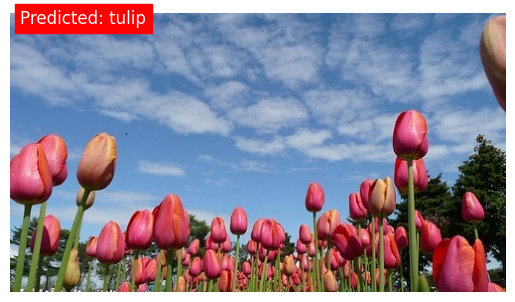

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()